 Создайте веб-сервис с помощью FastAPI, загрузите на него обученную модель MNIST и протестируйте ее на собственноручно написанных цифрах.




In [ ]:
# загрузка всего датасет MNIST

from tensorflow.keras.datasets import mnist      
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()               

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# подготовка набора экземпляров класса

x_train = x_train_org.reshape(x_train_org.shape[0], -1)   
x_test = x_test_org.reshape(x_test_org.shape[0], -1)   

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

In [ ]:
# подготовка набора меток класса

from tensorflow.keras import utils              
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [ ]:
# проверка размерностей

print(x_train.shape)
print(y_train.shape)  

(60000, 784)
(60000, 10)


## Решение

Создадим и обучим модель, сохраним ее полностью при помощи `model.save()`: 

In [ ]:
# загрузка библиотек

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam

In [ ]:
# Создание модели
model = Sequential()

# Добавление слоев
model.add(Dense(800, input_dim=784, activation='relu')) 
model.add(Dense(400, activation='relu')) 
model.add(Dense(10, activation='softmax')) 

# Компиляция модели
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train,              # Обучающая выборка  
                    y_train,              # Обучающая выборка меток класса
                    batch_size=8,         # Размер батча (пакета)
                    epochs=3,             # Количество эпох обучения
                    validation_split=0.1, # Доля проверочной выборки
                    verbose=1)            # Отображение хода обучения

# Сохранение модели
from keras.models import save_model
model.save('f_mnist.h5')   

Epoch 1/3
6750/6750 [==============================] - 55s 8ms/step - loss: 0.2022 - accuracy: 0.9394 - val_loss: 0.1336 - val_accuracy: 0.9595
Epoch 2/3
6750/6750 [==============================] - 54s 8ms/step - loss: 0.1018 - accuracy: 0.9706 - val_loss: 0.0957 - val_accuracy: 0.9733
Epoch 3/3
6750/6750 [==============================] - 51s 8ms/step - loss: 0.0734 - accuracy: 0.9786 - val_loss: 0.1615 - val_accuracy: 0.9653


In [ ]:
# Загрузка модели для скрипта

from keras.models import load_model
model = load_model('f_mnist.h5')

In [ ]:
# 1. Установка в среду FastAPI и вспомогательных библиотек

# фреймворк, предназначенный для организации REST API сервисов
!pip install fastapi

# ASGI-совместимый веб-сервер для запуска приложения
!pip install uvicorn 

# Отправка динамически сгенерированного файла (или файла из памяти) методом POST на удаленный сервер
!pip install python-multipart 

     |████████████████████████████████| 51 kB 595 kB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████| 10.9 MB 14.3 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=9cbc5e012018df3a2aba1529930d8a5f90727badd7f1e5e12343df761ffca368
  Stored in directory: /root/.cache/pip/wheels/2c/41/7c/bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
Successfully built python-multipart


Модель, созданная выше настроена на прием вектора из 784 элементов. Поэтому необходимо предварительно подготовить изображение перед подачей в сеть с учетом того, что обучающий и тестовый набор выглядят по разному. А именно:
- перевести в градации серого, 
- привести исходный размер к 28 * 28, 
- !!! инвертировать цвета, т.к.  в наборе белые буквы на черном фоне, а у нас наоборот - синие на белом
- !!! избавиться от шумов, дотянув цвет до белого или черного
- преобразовать в numpy-массив
- вытянуть в вектор.

Чтобы описанное выше произошло на сервере, когда мы отправим ему изображение для получения предсказания, создадим `predict_file` с описанием логики работы сервера.

Дополнительно файл должен содержать импортированные библиотеки, саму модель, запуск предсказания и его возврат:

In [ ]:
predict_file = '''

from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img 
from io import BytesIO
from PIL import Image 

INPUT_SHAPE = (28, 28)

model = load_model('f_mnist.h5') # Инициализируем модель

def process(image_file):
    
    # Открываем обрабатываемый файл и переводим в градации серого
    img = Image.open(BytesIO(image_file)).convert('L')

    # Приводим размерность в соответствии с входом сети
    resized_image = img.resize((INPUT_SHAPE[1], INPUT_SHAPE[0]))     

    # Инвертируем цвета, нормируем и переводим в numpy-массив
    resized_image = np.array(1 - np.array(resized_image) / 255)

    # Избавляемся от шумов, преобразуя значения пикселей к 0 (фон) или 1 (цифра)
    resized_image[resized_image < 0.5] = 0
    resized_image[resized_image >= 0.5] = 1

    # Вытягиваем в вектор
    resized_image = resized_image.reshape(1, 784)    

    # Запускаем предсказание
    prediction_array = model.predict(resized_image)[0] 

    # Возвращаем предсказание сети в виде словаря
    return str({str(i): r for i, r in enumerate(prediction_array)})
'''

# Сохраняем код выше в файл
with open('predict.py', 'w') as file:
  file.write(predict_file)

Создадим эндпойнт, т.е. адрес, по которому можно сделать запрос через API. 

Назовем его `main_file`. Он отправит `predict_file` на сервер. Внутрь него поместим импорт необходимых библиотек, экземпляр класса `FastAPI()` и назовем его `app` и применим к нему метод `post`.

Далее определим функцию для работы с путями `create_file`. Т.к. приложению не нужно связываться ни с чем другим, а только ждать ответа, используем `async def`. Асинхронное программирование – это вид параллельного программирования, в котором какая-либо единица работы может выполняться отдельно от основного потока выполнения приложения. Когда работа завершается, основной поток получает уведомление о завершении рабочего потока или произошедшей ошибке. 

Функция принимает в качестве аргумента файл и возвращает предсказание:

In [ ]:
main_file = '''

from fastapi import FastAPI, File
from predict import process

app = FastAPI()

@app.post("/predict")
async def create_file(file: bytes = File(...)):
    return {"result": process(file)}'''

with open('main.py', 'w') as file:
  file.write(main_file)

In [ ]:
# 2. Запуск http-сервера uvicorn с указанием приложения, которое будет запущено (app из файла main.py)

!nohup uvicorn main:app --reload &

nohup: appending output to 'nohup.out'


In [ ]:
# Посмотрим логи сервера

!cat nohup.out

Протестируем работу сети на сервере. 

Подготовим самописный набор:

In [ ]:
# Загрузка собственных рукописных цифр из облака

import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l3/hw_upro.zip', None, quiet=True)

'hw_upro.zip'

In [ ]:
!unzip -q hw_upro.zip

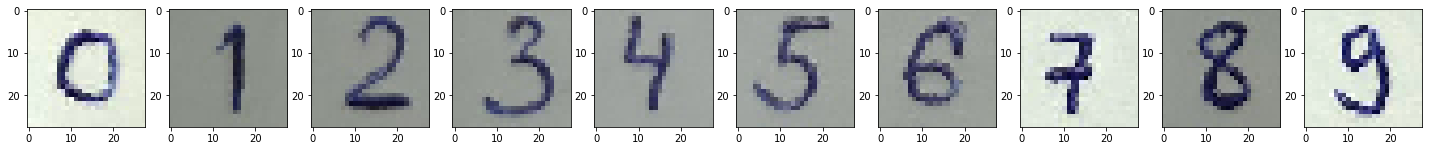

In [ ]:
# Метод для загрузки изображений
from tensorflow.keras.preprocessing.image import load_img 

# Вывод для примера картинок по каждому классу

# Создание полотна из десяти графиков
import matplotlib.pyplot as plt  
fig, axs = plt.subplots(1, 10, figsize=(25, 5)) 

# Проход и отрисовка по всем классам
for i in range(10):
    img = load_img('digits/' + str(i) + '.png', target_size=(28, 28)) 
    axs[i].imshow(img, cmap = 'gray')

# Вывод изображений
plt.show() 

Протестируем наши тестовые изображения:

Тестовое изображение:


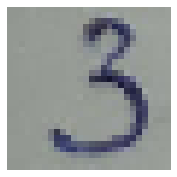

Ответ модели: 3


Тестовое изображение:


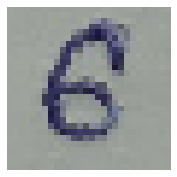

Ответ модели: 8


Тестовое изображение:


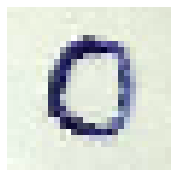

Ответ модели: 0


Тестовое изображение:


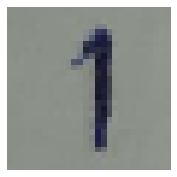

Ответ модели: 9


Тестовое изображение:


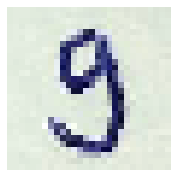

Ответ модели: 3


Тестовое изображение:


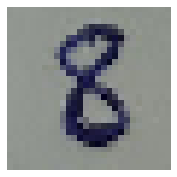

Ответ модели: 8


Тестовое изображение:


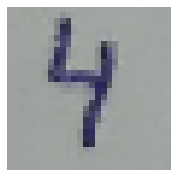

Ответ модели: 4


Тестовое изображение:


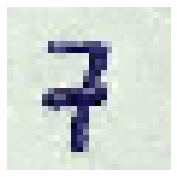

Ответ модели: 7


Тестовое изображение:


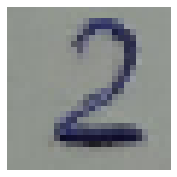

Ответ модели: 2


Тестовое изображение:


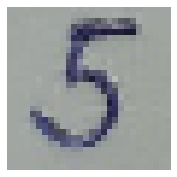

Ответ модели: 5




In [ ]:
import os
import requests
import json
import numpy as np

# Получаем список файлов в тестовой папке с изображениями
files = os.listdir('digits')    

# Проходим по всем файлам
for f in files:
  print('Тестовое изображение:')                                   # Вывод строки
  img = load_img('digits/' + f, target_size=(28, 28))              # Открытие изображения и приведение к размеру 28х28
  
  # Отображение картинки
  plt.figure(figsize = (3,3))                                      # Размер полотна
  plt.imshow(img)                                                  # Вывод
  plt.axis('off')                                                  # Отключение осей
  plt.show()

  files = {'file': open(f'digits/{f}','rb')}                       # Открытие файла для передачи на сервер
  r = requests.post('http://127.0.0.1:8000/predict', files=files)  # Отправка запроса на сервер
  result = r.json()['result'].replace("'","\"")                    # Парсинг ответа (замена одного апострофа на двойные кавычки Требуется для преобразования строки в словарь)
  result = json.loads(result)                                      # Проберазуем строку ответа к типу словарь
  print(f'Ответ модели: {np.argmax(list(result.values()))}')       # Печатаем ответ нейронки
  print()
  print()